In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint
from keras import regularizers

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

In [3]:
# load our sample data 
df = pd.read_csv('./sample_credit_card_fraud.csv')

In [4]:
# inspect the data
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


In [6]:
# check our columns (we see that a bunch of them are unknown to us but that's ok since our model can use these use them
# perform its classification and help us identify items that don't match the trends that it finds)
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [7]:
# check to see if our set has any null values (we have none so we're all good)
df.isnull().values.any()

False

In [8]:
# inspect the shape of our data
df.shape

(284807, 31)

In [9]:
# inspect the classes that we have in our data (confirm that we only have two classes)
df['Class'].unique()

array([0, 1])

In [10]:
# separate our data set by classes since we want to only feed the normal transactions to our autoencoder
fraud_transactions = df[df.Class == 1]
normal_transactions = df[df.Class == 0]

In [11]:
# calculate the ratio of fraudentl transactions to normal ones
fraud_transactions.shape[0] / normal_transactions.shape[0]

0.0017304750013189597

In [12]:
# scale our data for the training set
from sklearn.preprocessing import StandardScaler

df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))

In [13]:
# checkout our scaled amounts
df['Amount'].head()

0    0.244964
1   -0.342475
2    1.160686
3    0.140534
4   -0.073403
Name: Amount, dtype: float64

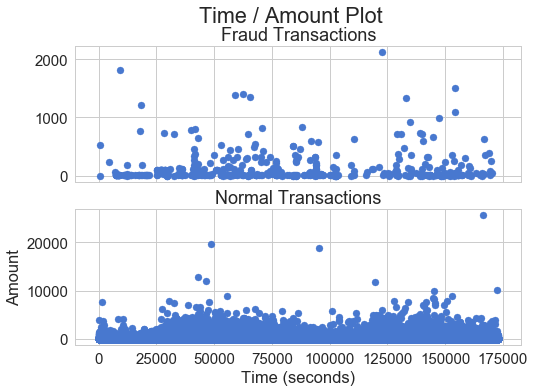

In [14]:
# plot the two features that we do know against each other to see if there is some kind of relationship
# looking at the data it doens't appear to so we can prob just drop the time values
figure, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
figure.suptitle('Time / Amount Plot')

ax1.scatter(fraud_transactions['Time'], fraud_transactions['Amount'])
ax1.set_title('Fraud Transactions')

ax2.scatter(normal_transactions['Time'], normal_transactions['Amount'])
ax2.set_title('Normal Transactions')

plt.xlabel('Time (seconds)')
plt.ylabel('Amount')

In [15]:
# remove time since it doesn't seem to have much impact
df = df.drop(['Time'], axis=1)

In [16]:
# train the model only on the normal transactions so that it is easy to identify fraudulent items
X_train, X_test = train_test_split(df, test_size=0.2, random_state=25)
X_train = X_train[X_train['Class'] == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [17]:
# create an autoencoder that uses 4 fully connected layers
input_dim = X_train.shape[1]
encoding_dim = 14

# create our input layer
input_layer = Input(shape=(input_dim,))


# add our encoders
encoder = Dense(encoding_dim, 
                activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), 
                activation="relu")(encoder)

# add our decoders
decoder = Dense(int(encoding_dim / 2), 
                activation='tanh')(encoder)
decoder = Dense(input_dim, 
                activation='relu')(decoder)

#create our autoeoncoder
model = Model(inputs=input_layer, outputs=decoder)

In [18]:
# compile the autoencoder using Adam for stotastic optimization and
# minimizing the mean squared error as our loss function
model.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

# save our model after each epoch
checkpoint = ModelCheckpoint(filepath="credit_card_fraud_model.h5",
                               verbose=0,
                               save_best_only=True)

# train the model
model.fit(X_train, X_train,
                epochs=100,
                batch_size=30,
                shuffle=True,
                validation_data=(X_test, X_test),
                verbose=1,
                callbacks=[checkpoint])

Train on 227465 samples, validate on 56962 samples
Epoch 1/100
227465/227465 [==============================] - 19s - loss: 0.8084 - acc: 0.5909 - val_loss: 0.8039 - val_acc: 0.6550
Epoch 2/100
227465/227465 [==============================] - 19s - loss: 0.7428 - acc: 0.6611 - val_loss: 0.7861 - val_acc: 0.6648
Epoch 3/100
227465/227465 [==============================] - 19s - loss: 0.7320 - acc: 0.6650 - val_loss: 0.7784 - val_acc: 0.6685
Epoch 4/100
227465/227465 [==============================] - 19s - loss: 0.7268 - acc: 0.6663 - val_loss: 0.7743 - val_acc: 0.6670
Epoch 5/100
227465/227465 [==============================] - 19s - loss: 0.7226 - acc: 0.6707 - val_loss: 0.7724 - val_acc: 0.6818
Epoch 6/100
227465/227465 [==============================] - 19s - loss: 0.7207 - acc: 0.6739 - val_loss: 0.7811 - val_acc: 0.6564
Epoch 7/100
227465/227465 [==============================] - 19s - loss: 0.7196 - acc: 0.6749 - val_loss: 0.7684 - val_acc: 0.6838
Epoch 8/100
227465/227465 [=====

227465/227465 [==============================] - 19s - loss: 0.7063 - acc: 0.7028 - val_loss: 0.7587 - val_acc: 0.6967
Epoch 63/100
227465/227465 [==============================] - 20s - loss: 0.7065 - acc: 0.7024 - val_loss: 0.7548 - val_acc: 0.7065
Epoch 64/100
227465/227465 [==============================] - 19s - loss: 0.7062 - acc: 0.7027 - val_loss: 0.7589 - val_acc: 0.7032
Epoch 65/100
227465/227465 [==============================] - 19s - loss: 0.7067 - acc: 0.7028 - val_loss: 0.7579 - val_acc: 0.7050
Epoch 66/100
227465/227465 [==============================] - 19s - loss: 0.7061 - acc: 0.7017 - val_loss: 0.7557 - val_acc: 0.7111
Epoch 67/100
227465/227465 [==============================] - 19s - loss: 0.7063 - acc: 0.7027 - val_loss: 0.7562 - val_acc: 0.7048
Epoch 68/100
227465/227465 [==============================] - 19s - loss: 0.7067 - acc: 0.7029 - val_loss: 0.7552 - val_acc: 0.7098
Epoch 69/100
227465/227465 [==============================] - 21s - loss: 0.7061 - acc: 0

In [19]:
model = load_model('credit_card_fraud_model.h5')

In [25]:
# set our threshold, anything over this amount will be marked as fraud
from sklearn.metrics import auc, confusion_matrix, precision_recall_curve, roc_curve
threshold = 4

In [26]:
# make a model predictions from our test data
predictions = model.predict(X_test)

In [27]:
# calculate the mean squared error and store it as a frame
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
errors = pd.DataFrame({'reconstruction': mse, 'trues': y_test})

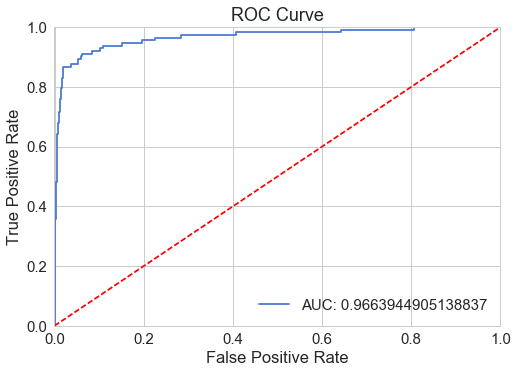

In [32]:
# take a look at our ROC curve, which appears to have the general shape we are looking for
# but a confusion matrix may provide more insight
false_positive_rate, true_positive_rate, thresholds = roc_curve(errors['trues'], errors['reconstruction'])
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.title('ROC Curve')
plt.plot(false_positive_rate, true_positive_rate, label='AUC: {}'.format(area_under_curve))
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

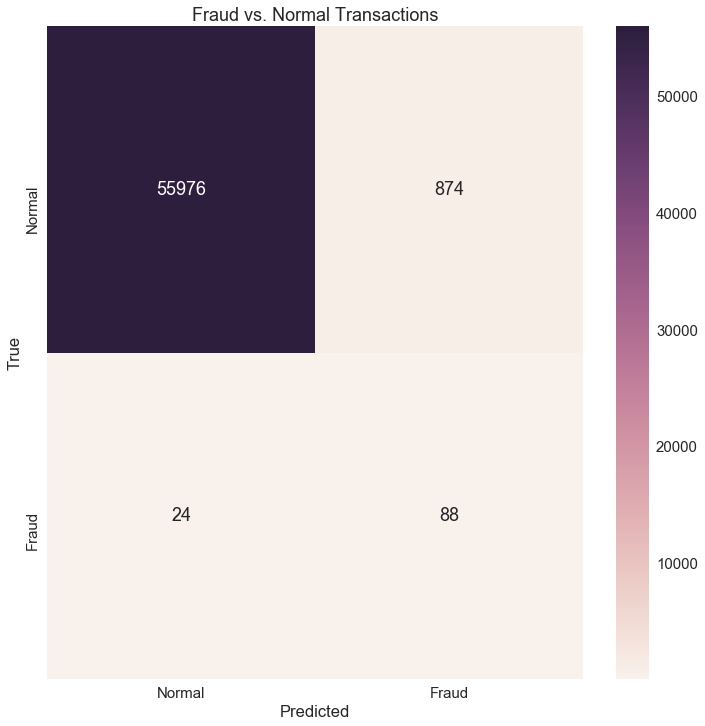

In [34]:
# build a confusion matrix of our results
y_hat = [1 if error > threshold else 0 for error in errors['reconstruction'].values]
conf_matrix = confusion_matrix(errors['trues'], y_hat)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, 
            xticklabels=["Normal", "Fraud"], 
            yticklabels=["Normal", "Fraud"], 
            annot=True, fmt="d");
plt.title("Fraud vs. Normal Transactions")
plt.ylabel('True')
plt.xlabel('Predicted')

## Observations

We see that we do a decent job of classifying normal transactions but we could do a little better at classifying normal transactions since we incorrectly mark almost a thousand of them as fraudulent when they were not. We can tweak our threshold values, drop features, etc. to try to get a better result or make changes at the raw TensorFlow level to fine-tune these results.